In [68]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# In this notebook, we'll explore a few methods in Spark Core
### Creating RDDs, collect(), map(), join(), reduceByKey(), aggregateByKey(), and filter()

### We'll start with an online-dating dataset, described here: https://sites.google.com/a/insightdatascience.com/spark-lab/s3-data/dating-profiles

### Here we create an RDD from a csv stored in s3, and use the collect() action, which returns an array


In [69]:
#a csv of id, users
rawUsersRDD = sc.textFile("s3n://insight-spark-after-dark/users-sm.csv")
rawUsersRDD.collect()

[u'10001,Tony',
 u'10002,Mike',
 u'10003,Pat',
 u'10004,Chris',
 u'10005,Paco',
 u'10006,Eddie',
 u'90001,Lisa',
 u'90002,Cindy',
 u'90003,Paula',
 u'90004,Leslie',
 u'90005,Allman',
 u'90006,Kimberly']

### The collect action causes data to flow across the network from the worker nodes to the master (where you are running the jupyter notebook, or your data analysis)


In [70]:
#a csv of id, genders
rawGendersRDD = sc.textFile("s3n://insight-spark-after-dark/gender-sm.csv")
rawGendersRDD.collect()

[u'10001,M',
 u'10002,M',
 u'10003,M',
 u'10004,M',
 u'10005,M',
 u'10006,M',
 u'90001,F',
 u'90002,F',
 u'90003,F',
 u'90004,F',
 u'90005,F',
 u'90006,F']

In [71]:
def rec_tup(record):
    tokens = record.split(",")
    return (int(tokens[0]), str(tokens[1]))

### Moving toward a join action, we can use the map() method to create Key/Value pairs from the tuple

In [72]:
usersRDD = rawUsersRDD.map(rec_tup)
usersRDD.collect()

[(10001, 'Tony'),
 (10002, 'Mike'),
 (10003, 'Pat'),
 (10004, 'Chris'),
 (10005, 'Paco'),
 (10006, 'Eddie'),
 (90001, 'Lisa'),
 (90002, 'Cindy'),
 (90003, 'Paula'),
 (90004, 'Leslie'),
 (90005, 'Allman'),
 (90006, 'Kimberly')]

In [73]:
gendersRDD = rawGendersRDD.map(rec_tup)
gendersRDD.collect()

[(10001, 'M'),
 (10002, 'M'),
 (10003, 'M'),
 (10004, 'M'),
 (10005, 'M'),
 (10006, 'M'),
 (90001, 'F'),
 (90002, 'F'),
 (90003, 'F'),
 (90004, 'F'),
 (90005, 'F'),
 (90006, 'F')]

### Now that we have two RDDs with Key/Value pairs, use the join method to join the RDDs based on the Key

In [74]:
usersWithGenderJoinedRDD = usersRDD.join(gendersRDD)
usersWithGenderJoinedRDD.collect()

[(90004, ('Leslie', 'F')),
 (10004, ('Chris', 'M')),
 (90005, ('Allman', 'F')),
 (90001, ('Lisa', 'F')),
 (10005, ('Paco', 'M')),
 (10001, ('Tony', 'M')),
 (90006, ('Kimberly', 'F')),
 (10002, ('Mike', 'M')),
 (90002, ('Cindy', 'F')),
 (10006, ('Eddie', 'M')),
 (10003, ('Pat', 'M')),
 (90003, ('Paula', 'F'))]

#### Task 1: There exists another zipped csv, s3n://insight-spark-after-dark/gender.csv.gz. Create an RDD called genders_raw

In [75]:
# Task 1: There exists another zipped csv, s3n://insight-spark-after-dark/gender.csv.gz.
# Create an RDD called genders_raw and read in the full gender file (UserId, gender).
genders_raw = sc.textFile("s3n://insight-spark-after-dark/gender.csv.gz")
genders_raw.take(5)

[u'1,F', u'2,F', u'3,U', u'4,F', u'5,F']

#### Task 2: Parse each of the record  from the genderRDDD so that we have a tuple of (gender(string), id(int)) and show 


In [76]:
# Task 2: Parse each of the record  from the genderRDDD so that we have a tuple of (gender(string), id(int)) and show 
split_rdd = genders_raw.map(lambda r: r.split(','))
parsed_rdd = split_rdd.map(lambda r: (r[1], int(r[0])))
parsed_rdd.take(5)

[(u'F', 1), (u'F', 2), (u'U', 3), (u'F', 4), (u'F', 5)]

#### Task 3: Calculate the distribution of Males, Females, and Unknowns and show the results


In [77]:
# Task 3: Calculate the distribution of Males, Females, and Unknowns and show the results
tagged_rdd = parsed_rdd.map(lambda r: (r[0], 1))
distribution = tagged_rdd.reduceByKey(lambda x,y: x+y)
distr = distribution.collect()
gender = [str(val[0]) for val in distr]
count = [val[1] for val in distr]

print gender
print count

['U', 'M', 'F']
[83164, 76441, 61365]


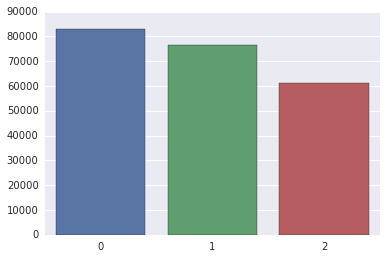

In [78]:
x = np.arange(3)
y = np.array(count)
sns.barplot(x,y)


#### Task 4: Calculate the sum of all the IDs for each gender


In [79]:
# Task 4: Calculate the sum of all the IDs for each gender
id_sum_rdd = parsed_rdd.reduceByKey(lambda x,y: x+y)
id_sum_rdd.collect()

[(u'U', 13105654827), (u'M', 6982853010), (u'F', 4325473098)]

#### Task 5: Calculate the average of all the IDs for each gender


In [80]:
# Task 5: Calculate the average of all the IDs for each gender
sum_cnt_rdd = parsed_rdd.aggregateByKey((0,0),
                                       lambda x,y: (x[0]+y, x[1]+1),
                                       lambda x,y: (x[0]+y[0], x[0]+y[0]))
avg_rdd = sum_cnt_rdd.mapValues(lambda r: r[0]/r[1])
avg_rdd.collect()

[(u'U', 157588), (u'M', 91349), (u'F', 70487)]

#### Task 6: Only return records from parsed_rdd which have ids that are a multiple of 5 and show the first 5 results


In [81]:
# Task 6: Only return records from parsed_rdd which have ids that are a multiple of 5 and 
# show the first 5 results
filtered_rdd = parsed_rdd.filter(lambda r: r[1]%5==0)
filtered_rdd.take(5)

[(u'F', 5), (u'M', 10), (u'U', 15), (u'M', 20), (u'F', 25)]